# Exercise 2  

## Initializing the Google Earth Engine 

In [1]:
import ee
import geemap

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

Enter verification code:  4/1AfJohXkjTfCCS8ZQph7BOeZhyKQ1c3xSoZAwVZmBmwLuL9L30z8DfgWO2ZM



Successfully saved authorization token.


In [3]:
try:
    # Initialize the library.
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


### Dask  

Using dask to read the multiple datasets at once

In [4]:
import dask.dataframe as dd
import pandas as pd

In [5]:
df = dd.read_csv('Data/SamplesSet*.csv')
print(df.head())
print(df.tail())

         lat        lon           landcover
0  66.186422  19.580600  ForestNaturalAreas
1  67.225224  22.139060  ForestNaturalAreas
2  68.564587  18.763001  ForestNaturalAreas
3  51.756201  24.713687               Water
4  47.705336  18.825144    AgriculturalArea
            lat        lon           landcover
4152  42.635008   4.372315               Water
4153  53.772584  -1.064018  ForestNaturalAreas
4154  40.468550   6.757071    AgriculturalArea
4155  51.167547  13.863001    AgriculturalArea
4156  56.511879  15.309247    AgriculturalArea


As can be seen in the combined data frame the index is not correct the cell below re indexes the data frame, so that the row number can be again the primary key

In [6]:
df = dd.read_csv('Data/SamplesSet*.csv')
df = df.compute()
df = df.reset_index(drop=True)
print(df.tail())

             lat        lon           landcover
40456  42.635008   4.372315               Water
40457  53.772584  -1.064018  ForestNaturalAreas
40458  40.468550   6.757071    AgriculturalArea
40459  51.167547  13.863001    AgriculturalArea
40460  56.511879  15.309247    AgriculturalArea


## Data exploration

This section of the code focuses on exploring what is in the code, what kind of land covers, and where is the majority of the points located

In [7]:
#if laze can be distinct_values = df['landcover'].drop_duplicates().compute()
distinct_values = df['landcover'].drop_duplicates()
print(distinct_values)
distinct_value_counts = df['landcover'].value_counts()
print(distinct_value_counts)

0       ForestNaturalAreas
3                    Water
4         AgriculturalArea
7                 Wetlands
14      ArtificialSurfaces
1299                   NaN
Name: landcover, dtype: object
ForestNaturalAreas    15944
AgriculturalArea      13788
Water                  8494
ArtificialSurfaces     1415
Wetlands                816
Name: landcover, dtype: int64


In [8]:
min_value_lat = df['lat'].min()
max_value_lat = df['lat'].max()

min_value_lon = df['lon'].min()
max_value_lon= df['lon'].max()

print(f"The lat min value is: {min_value_lat} and max: {max_value_lat}")
print(f"The lat min value is: {min_value_lon} and max: {max_value_lon}")

The lat min value is: 36.20076975509693 and max: 71.52708720156912
The lat min value is: -26.068806183526306 and max: 41.39790973452674


**The bounding box list**  

Find in which bounding box lies the majority of points, using the bounding box from comment by hduchesn on github in thread https://gist.github.com/graydon/11198540

In [9]:
import json

with open('bounding_boxes.json', 'r') as file:
    bounding_boxes = json.load(file)

In [11]:
# check if in bouding box
def is_in_bounding_box(lat, lon, bounding_box):
    sw = bounding_box['sw']
    ne = bounding_box['ne']
    return sw['lat'] <= lat <= ne['lat'] and sw['lon'] <= lon <= ne['lon']


dfs = []

# count locations in each bounding box
for code, box in bounding_boxes.items():
    country_name = code
    bounding_box = box
    min_lat, min_lon = bounding_box['sw']['lat'], bounding_box['sw']['lon']
    max_lat, max_lon = bounding_box['ne']['lat'], bounding_box['ne']['lon']
    filtered_df = df[df.apply(lambda row: is_in_bounding_box(row['lat'], row['lon'], bounding_box), axis=1)]
    count = len(filtered_df)
    bounding_box_df = dd.from_pandas(pd.DataFrame({'Country': [country_name], 'Code': [code], 'Count': [count]}), npartitions=1)
    dfs.append(bounding_box_df)

counts_df = dd.concat(dfs)

Plot the top 20 countries with most location from the dataset

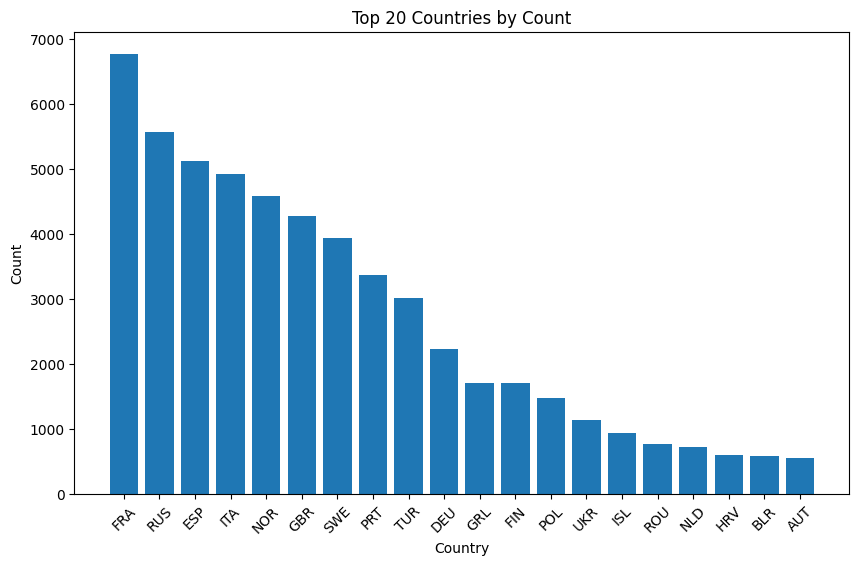

In [12]:
import matplotlib.pyplot as plt

top_scores = counts_df.nlargest(20, 'Count')
top_scores_pd = top_scores.compute()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_scores_pd['Country'], top_scores_pd['Count'])
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 20 Countries by Count')
plt.xticks(rotation=45)
plt.show()

Based on the number of results located in a bounding box we decided to choose the France's bounding box 

**Get only the data frame of points in France**

In [10]:
min_latitude = 41.303
max_latitude = 51.124
min_longitude = -5.142
max_longitude = 9.561

# Filter points within the bounding box
france_points = df[
    (df['lat'] >= min_latitude) & 
    (df['lat'] <= max_latitude) & 
    (df['lon'] >= min_longitude) & 
    (df['lon'] <= max_longitude)
]

france_points = france_points.reset_index(drop=True)

print(france_points.tail())

            lat       lon           landcover
6333  45.997465  0.743937  ForestNaturalAreas
6334  44.776113  0.357572    AgriculturalArea
6335  51.094544  4.601532    AgriculturalArea
6336  42.310443  6.377444               Water
6337  42.635008  4.372315               Water


Reducing the number of points

In [11]:
bounding_box_smaller = ee.Geometry.Rectangle([-3.142, 43.303, 6.561, 49.124])

In [12]:
min_latitude = 43.303
max_latitude = 49.124
min_longitude = -3.142
max_longitude = 6.561

# Filter points within the bounding box
france_points_small = df[
    (df['lat'] >= min_latitude) & 
    (df['lat'] <= max_latitude) & 
    (df['lon'] >= min_longitude) & 
    (df['lon'] <= max_longitude)
]

france_points_small = france_points_small.reset_index(drop=True)

print(france_points_small.tail())

            lat       lon           landcover
2692  48.719424  3.488222  ForestNaturalAreas
2693  44.669344  0.413262    AgriculturalArea
2694  47.536590  2.006475    AgriculturalArea
2695  45.997465  0.743937  ForestNaturalAreas
2696  44.776113  0.357572    AgriculturalArea


## Sentinel image  

Loading the Sentinel image for summer in France and filtering out the images with clouds on. The percentage of Cloudy pixel below 30 is enough as it will be compensated by the median, the map does not need to be continuous - if there are small factor that is all right.

In [13]:
# get the image
bounding_box = ee.Geometry.Rectangle([-5.4534286, 41.2632185, 9.8678344, 51.268318])
center = bounding_box.centroid()

map_france = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
  .filterBounds(bounding_box)\
  .filterDate('2023-06-01', '2023-08-30')\
  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 30) \
  .sort('CLOUDY_PIXEL_PERCENTAGE', False)


In [14]:
# get number of images in collection
listOfImages = map_france.aggregate_array('system:index').getInfo()
print('Number of images in the collection: ', len(listOfImages))


Number of images in the collection:  3007


In [15]:
# Set visualization parameters for land cover R, G, B
vis_params = {"min": 0, 
              "max": 4000, 
              "bands": ["B4", "B3", "B2"]}  

# calculate the median of the image
median_image = map_france.median()

In [16]:
#initialize and display the original map
Map = geemap.Map()
Map.addLayer(median_image, vis_params, "Median", True) 
Map.centerObject(center, 5)
Map

Map(center=[46.36657487868256, 2.207202899999996], controls=(WidgetControl(options=['position', 'transparent_b…

# Proceed with clustering 

First we check what bands are available in the image

In [17]:
# get the available bands 
bandNames = median_image.bandNames() 
print('Band names: ', bandNames.getInfo()) # ee.List of band names 

Band names:  ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']


## Start training

In [158]:
%%time
training = median_image.sample(**{
    'region':bounding_box,
    'scale': 30,
    'numPixels': 10000,
    'seed': 0,
    'tileScale' : 2,
    'geometries': True # the geometries are not included
})

CPU times: user 195 µs, sys: 55 µs, total: 250 µs
Wall time: 278 µs


Display the training results

In [159]:
Map.addLayer(training, {}, 'training', False)
Map

Map(bottom=3203.0, center=[46.34777003755111, 2.2390951036287725], controls=(WidgetControl(options=['position'…

In [122]:
%time
n_clusters = 5
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# Cluster the input using the trained clusterer.
result = median_image.cluster(clusterer)

CPU times: user 15 µs, sys: 4 µs, total: 19 µs
Wall time: 37.2 µs


In [ ]:
cluster_ids = result.select(['cluster'])
print(cluster_ids)

In [95]:
Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(bottom=3200.0, center=[46.437856895024204, 3.8004766678897144], controls=(WidgetControl(options=['position…

Assign custom colors to the bands - visual aid to determine which band is which

In [96]:
palette = ['ff0000', '00ff00', '0000ff', 'ffff00', 'ff00ff'] # Add or modify colors as needed

# Create a visualization parameter with the specified palette
vis_params = {'min': 0, 'max': n_clusters - 1, 'palette': palette}

# Add the clustered result to the map using the custom visualization parameters
Map.addLayer(result, vis_params, 'clusters')

Map

Map(bottom=3200.0, center=[46.437856895024204, 3.8004766678897144], controls=(WidgetControl(options=['position…

# Assessing the performance

In [129]:
def get_cluster_for_coordinates(lat, lon):
    point = ee.Geometry.Point(lon, lat)
    cluster = result.reduceRegion(ee.Reducer.first(), point, 80)  # Adjust the scale as needed
    return cluster.get('cluster').getInfo()

france_points['cluster'] = france_points.apply(lambda row: get_cluster_for_coordinates(row['lat'], row['lon']), axis=1)
france_points.head()


,lat,lon,landcover,cluster
0,46.039497,-2.452921,ForestNaturalAreas,2
1,47.069038,-2.747037,ForestNaturalAreas,2
2,44.641800,3.855142,ForestNaturalAreas,0
3,47.590344,4.352115,AgriculturalArea,3
4,44.719964,-1.344896,AgriculturalArea,2


In [130]:
print(france_points.head())

         lat       lon           landcover  cluster
0  46.039497 -2.452921  ForestNaturalAreas        2
1  47.069038 -2.747037  ForestNaturalAreas        2
2  44.641800  3.855142  ForestNaturalAreas        0
3  47.590344  4.352115    AgriculturalArea        3
4  44.719964 -1.344896    AgriculturalArea        2


In [22]:
import pickle

In [132]:
with open('france_points_big.pickle', 'wb') as handle:
    pickle.dump(france_points, handle)

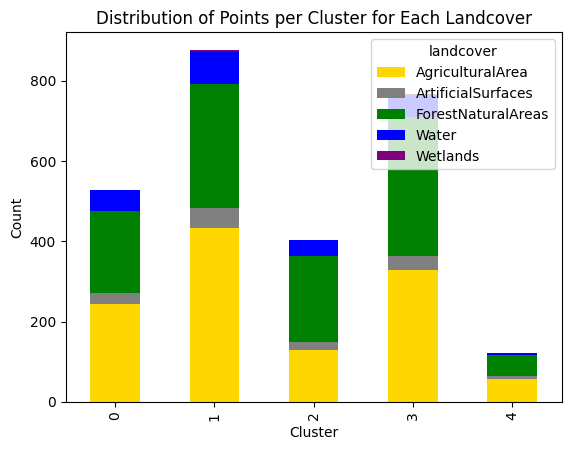

In [133]:
grouped_data = france_points.groupby(['cluster', 'landcover']).size().reset_index(name='count')

# Pivot the data to create a table suitable for plotting
pivot_data = grouped_data.pivot(index='cluster', columns='landcover', values='count').fillna(0)

colors = {
    'Water': 'blue',
    'ForestNaturalAreas': 'green',
    'ArtificialSurfaces': 'grey',
    'Wetlands': 'purple',
    'AgriculturalArea': '#FFD700'
}

# Plotting with custom colors
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Points per Cluster for Each Landcover')
plt.show()

It shows that the clustering algorithm did no do to well

# Poland - try no 2

In [18]:
min_latitude = 49.0020468
max_latitude = 55.0336963
min_longitude = 14.1229707
max_longitude = 24.145783


# Filter points within the bounding box
pol_points = df[
    (df['lat'] >= min_latitude) & 
    (df['lat'] <= max_latitude) & 
    (df['lon'] >= min_longitude) & 
    (df['lon'] <= max_longitude)
]

pol_points = pol_points.reset_index(drop=True)
pol_points.tail()

,lat,lon,landcover
1464,53.372462,20.347381,AgriculturalArea
1465,54.591151,20.857160,Water
1466,54.543125,21.584504,ForestNaturalAreas
1467,51.554761,14.374913,ForestNaturalAreas
1468,53.458657,21.984004,ArtificialSurfaces


In [19]:
bounding_box_pol = ee.Geometry.Rectangle([14.1229707,49.0020468,24.145783,55.0336963])

center = bounding_box_pol.centroid()

map_pol = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
  .filterBounds(bounding_box_pol)\
  .filterDate('2023-06-01', '2023-08-30')\
  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 25)

vis_params = {"min": 0, 
              "max": 4000, 
              "bands": ["B4", "B3", "B2"]}  

median_pol = map_pol.median()


MapPol = geemap.Map()
MapPol.addLayer(median_pol, vis_params, "Median", True) 
MapPol.centerObject(center, 5)
MapPol

Map(center=[52.056013452326226, 19.134376850000006], controls=(WidgetControl(options=['position', 'transparent…

In [20]:
%%time
training_pol = median_pol.sample(**{
    'region':bounding_box_pol,
    'scale': 30,
    'numPixels': 6000,
    'seed': 0,
    'tileScale' : 4,
    'geometries': True # the geometries are not included
})

CPU times: user 61 µs, sys: 11 µs, total: 72 µs
Wall time: 75.1 µs


In [160]:
MapPol.addLayer(training_pol, {}, 'training', False)
MapPol

Map(bottom=1729.0, center=[47.68305958029958, 42.47517226919228], controls=(WidgetControl(options=['position',…

In [166]:
n_clusters = 5
clusterer_pol = ee.Clusterer.wekaKMeans(n_clusters).train(training_pol)

# Cluster the input using the trained clusterer.
result_pol = median_pol.cluster(clusterer_pol)

In [169]:
def get_cluster_for_coordinates_pol(lat, lon):
    point = ee.Geometry.Point(lon, lat)
    cluster = result_pol.reduceRegion(ee.Reducer.first(), point, 80)  # Adjust the scale as needed
    return cluster.get('cluster').getInfo()

In [170]:
pol_points['cluster'] = pol_points.apply(lambda row: get_cluster_for_coordinates_pol(row['lat'], row['lon']), axis=1)
pol_points.head()

,lat,lon,landcover,cluster
0,50.528283,17.876719,AgriculturalArea,4
1,52.834085,16.995086,AgriculturalArea,4
2,51.662047,22.945717,AgriculturalArea,1
3,50.948002,19.535284,AgriculturalArea,3
4,53.840378,23.110183,Water,1


In [171]:
with open('pol_points.pickle', 'wb') as handle:
    pickle.dump(pol_points, handle)

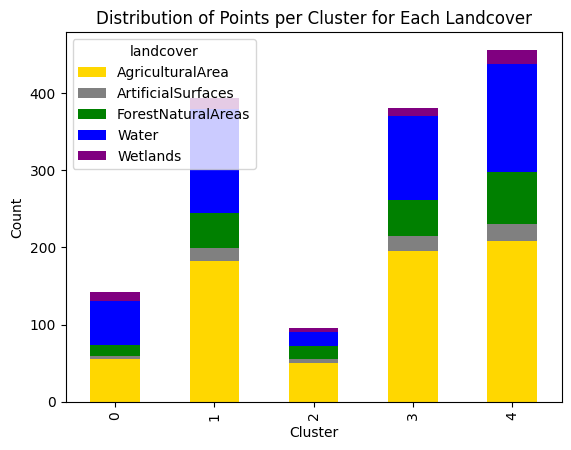

In [172]:
grouped_data = pol_points.groupby(['cluster', 'landcover']).size().reset_index(name='count')

# Pivot the data to create a table suitable for plotting
pivot_data = grouped_data.pivot(index='cluster', columns='landcover', values='count').fillna(0)

colors = {
    'Water': 'blue',
    'ForestNaturalAreas': 'green',
    'ArtificialSurfaces': 'grey',
    'Wetlands': 'purple',
    'AgriculturalArea': '#FFD700'
}

# Plotting with custom colors
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Points per Cluster for Each Landcover')
plt.show()

In [173]:
map_france_small = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
  .filterBounds(bounding_box_smaller)\
  .filterDate('2023-06-01', '2023-08-30')\
  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 30)


bands_of_interest = ['B2', 'B3', 'B4']  # Assuming B4 is Red, B3 is Green, B2 is Blue

map_smaller = map_france_small.select(bands_of_interest)
map_smaller_median = map_smaller.median()



In [174]:
training_small = map_smaller_median.sample(**{
    'region':bounding_box_smaller,
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'tileScale' : 8,
    'geometries': True # the geometries are not included
})

In [175]:
n_clusters = 5
clusterer_france = ee.Clusterer.wekaKMeans(n_clusters).train(training_small)

# Cluster the input using the trained clusterer.
result_france_small = map_smaller_median.cluster(clusterer_france)

In [176]:
def get_cluster_for_coordinates_small(lat, lon):
    point = ee.Geometry.Point(lon, lat)
    cluster = result_france_small.reduceRegion(ee.Reducer.first(), point, 80)  # Adjust the scale as needed
    return cluster.get('cluster').getInfo()

In [177]:
france_points_small['cluster'] = france_points_small.apply(lambda row: get_cluster_for_coordinates_small(row['lat'], row['lon']), axis=1)
france_points_small.head()

,lat,lon,landcover,cluster
0,46.039497,-2.452921,ForestNaturalAreas,1
1,47.069038,-2.747037,ForestNaturalAreas,1
2,44.641800,3.855142,ForestNaturalAreas,1
3,47.590344,4.352115,AgriculturalArea,4
4,44.719964,-1.344896,AgriculturalArea,1


In [178]:
with open('france_points_bands.pickle', 'wb') as handle:
    pickle.dump(france_points_small, handle)

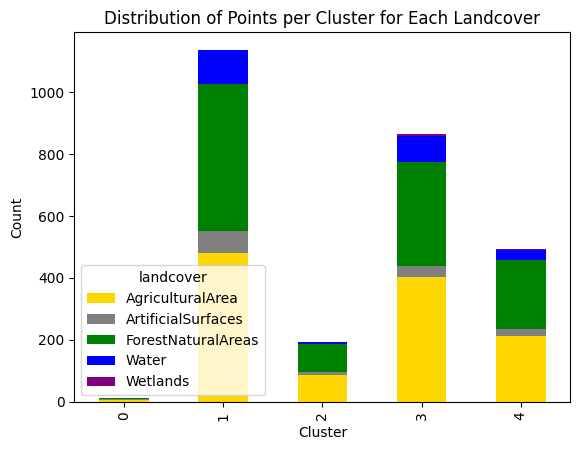

In [179]:
grouped_data = france_points_small.groupby(['cluster', 'landcover']).size().reset_index(name='count')

# Pivot the data to create a table suitable for plotting
pivot_data = grouped_data.pivot(index='cluster', columns='landcover', values='count').fillna(0)

colors = {
    'Water': 'blue',
    'ForestNaturalAreas': 'green',
    'ArtificialSurfaces': 'grey',
    'Wetlands': 'purple',
    'AgriculturalArea': '#FFD700'
}

# Plotting with custom colors
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Points per Cluster for Each Landcover')
plt.show()

In [180]:
n_clusters = 3
clusterer_pol = ee.Clusterer.wekaKMeans(n_clusters).train(training_pol)

# Cluster the input using the trained clusterer.
result_pol = median_pol.cluster(clusterer_pol)
pol_points['cluster'] = pol_points.apply(lambda row: get_cluster_for_coordinates_pol(row['lat'], row['lon']), axis=1)
pol_points.head()

,lat,lon,landcover,cluster
0,50.528283,17.876719,AgriculturalArea,1
1,52.834085,16.995086,AgriculturalArea,1
2,51.662047,22.945717,AgriculturalArea,2
3,50.948002,19.535284,AgriculturalArea,1
4,53.840378,23.110183,Water,2


In [181]:
with open('pol_points_less_cluster.pickle', 'wb') as handle:
    pickle.dump(pol_points, handle)

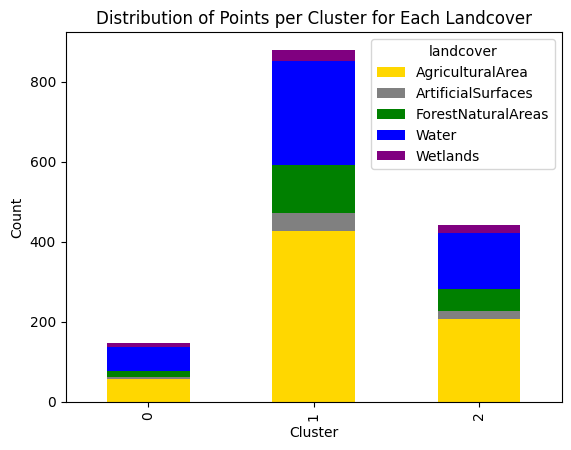

In [182]:
grouped_data = pol_points.groupby(['cluster', 'landcover']).size().reset_index(name='count')

# Pivot the data to create a table suitable for plotting
pivot_data = grouped_data.pivot(index='cluster', columns='landcover', values='count').fillna(0)

colors = {
    'Water': 'blue',
    'ForestNaturalAreas': 'green',
    'ArtificialSurfaces': 'grey',
    'Wetlands': 'purple',
    'AgriculturalArea': '#FFD700'
}

# Plotting with custom colors
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Points per Cluster for Each Landcover')
plt.show()

In [183]:
n_clusters = 4
clusterer_pol = ee.Clusterer.wekaKMeans(n_clusters).train(training_pol)

# Cluster the input using the trained clusterer.
result_pol = median_pol.cluster(clusterer_pol)
pol_points['cluster'] = pol_points.apply(lambda row: get_cluster_for_coordinates_pol(row['lat'], row['lon']), axis=1)
pol_points.head()

,lat,lon,landcover,cluster
0,50.528283,17.876719,AgriculturalArea,2
1,52.834085,16.995086,AgriculturalArea,2
2,51.662047,22.945717,AgriculturalArea,1
3,50.948002,19.535284,AgriculturalArea,3
4,53.840378,23.110183,Water,1


In [184]:
with open('pol_points_less_cluster_4.pickle', 'wb') as handle:
    pickle.dump(pol_points, handle)

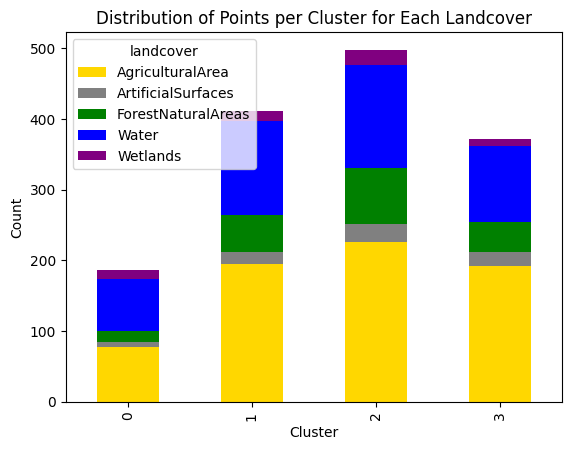

In [185]:
grouped_data = pol_points.groupby(['cluster', 'landcover']).size().reset_index(name='count')

# Pivot the data to create a table suitable for plotting
pivot_data = grouped_data.pivot(index='cluster', columns='landcover', values='count').fillna(0)

colors = {
    'Water': 'blue',
    'ForestNaturalAreas': 'green',
    'ArtificialSurfaces': 'grey',
    'Wetlands': 'purple',
    'AgriculturalArea': '#FFD700'
}

# Plotting with custom colors
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Points per Cluster for Each Landcover')
plt.show()

In [186]:
n_clusters = 2
clusterer_pol = ee.Clusterer.wekaKMeans(n_clusters).train(training_pol)

# Cluster the input using the trained clusterer.
result_pol = median_pol.cluster(clusterer_pol)
pol_points['cluster'] = pol_points.apply(lambda row: get_cluster_for_coordinates_pol(row['lat'], row['lon']), axis=1)
pol_points.head()

,lat,lon,landcover,cluster
0,50.528283,17.876719,AgriculturalArea,1
1,52.834085,16.995086,AgriculturalArea,1
2,51.662047,22.945717,AgriculturalArea,1
3,50.948002,19.535284,AgriculturalArea,0
4,53.840378,23.110183,Water,0


In [187]:
with open('pol_points_less_cluster_2.pickle', 'wb') as handle:
    pickle.dump(pol_points, handle)

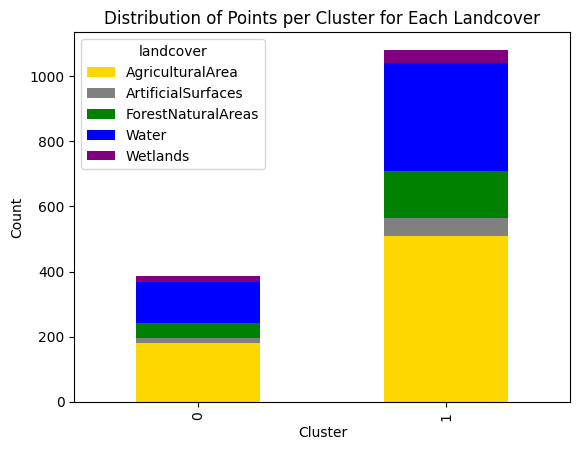

In [188]:
grouped_data = pol_points.groupby(['cluster', 'landcover']).size().reset_index(name='count')

# Pivot the data to create a table suitable for plotting
pivot_data = grouped_data.pivot(index='cluster', columns='landcover', values='count').fillna(0)

colors = {
    'Water': 'blue',
    'ForestNaturalAreas': 'green',
    'ArtificialSurfaces': 'grey',
    'Wetlands': 'purple',
    'AgriculturalArea': '#FFD700'
}

# Plotting with custom colors
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Points per Cluster for Each Landcover')
plt.show()

In [ ]:
n_clusters = 10
clusterer_pol = ee.Clusterer.wekaKMeans(n_clusters).train(training_pol)

# Cluster the input using the trained clusterer.
result_pol = median_pol.cluster(clusterer_pol)
pol_points['cluster'] = pol_points.apply(lambda row: get_cluster_for_coordinates_pol(row['lat'], row['lon']), axis=1)
pol_points.head()

In [ ]:
with open('pol_points_cluster_10.pickle', 'wb') as handle:
    pickle.dump(pol_points, handle)

In [23]:
file = open('pol_points_cluster_10.pickle', 'rb')
pol_points = pickle.load(file)
file.close()

NameError: name 'plt' is not defined

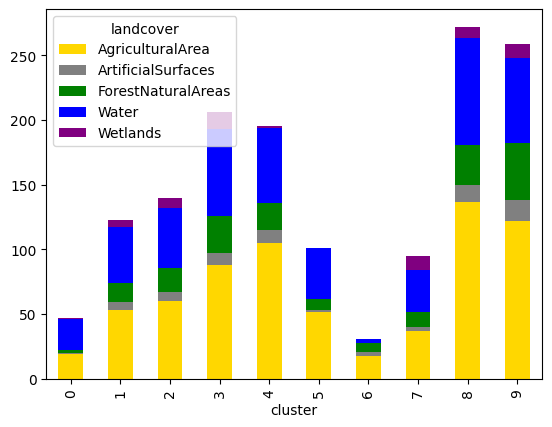

In [24]:
grouped_data = pol_points.groupby(['cluster', 'landcover']).size().reset_index(name='count')

# Pivot the data to create a table suitable for plotting
pivot_data = grouped_data.pivot(index='cluster', columns='landcover', values='count').fillna(0)

colors = {
    'Water': 'blue',
    'ForestNaturalAreas': 'green',
    'ArtificialSurfaces': 'grey',
    'Wetlands': 'purple',
    'AgriculturalArea': '#FFD700'
}

# Plotting with custom colors
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Points per Cluster for Each Landcover')
plt.show()

In [ ]:
n_clusters = 12
clusterer_pol = ee.Clusterer.wekaKMeans(n_clusters).train(training_pol)

# Cluster the input using the trained clusterer.
result_pol = median_pol.cluster(clusterer_pol)
pol_points['cluster'] = pol_points.apply(lambda row: get_cluster_for_coordinates_pol(row['lat'], row['lon']), axis=1)
pol_points.head()

In [ ]:
with open('pol_points_cluster_12.pickle', 'wb') as handle:
    pickle.dump(pol_points, handle)

In [26]:
file = open('pol_points_cluster_12.pickle', 'rb')
pol_points = pickle.load(file)
file.close()

NameError: name 'plt' is not defined

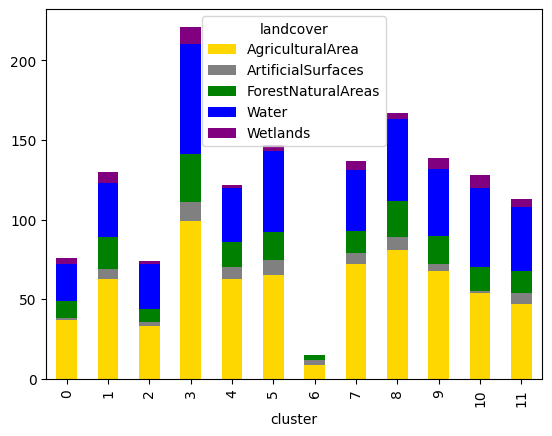

In [27]:
grouped_data = pol_points.groupby(['cluster', 'landcover']).size().reset_index(name='count')

# Pivot the data to create a table suitable for plotting
pivot_data = grouped_data.pivot(index='cluster', columns='landcover', values='count').fillna(0)

colors = {
    'Water': 'blue',
    'ForestNaturalAreas': 'green',
    'ArtificialSurfaces': 'grey',
    'Wetlands': 'purple',
    'AgriculturalArea': '#FFD700'
}

# Plotting with custom colors
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Points per Cluster for Each Landcover')
plt.show()